## Representative image as mean of reduced images

#### Question-1: Grayscale images of 15 subjects under 10 different conditions were obtained and are given in the file Dataset_Question1. Due to storage limitations, only one representative image can be stored for each subject in the database for future automated facial recognition purposes. Perform SVD on all the images for a subject to identify characteristic features that will be stored for each subject. Only this information should be used in the future automated facial recognition tasks. In the report, please show the representative images of all the subjects. Given an image, the facial recognition method is based on the smallest norm between the image and the representative images in the database. Determine the number of images out of 150 that you are able to correctly identify based on this approach in terms of accuracy. MATLAB image processing functions or python image processing libraries are not to be used for this assignment.

In [1]:
# Resetting variables
%reset -f

In [2]:
# Importing libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.image import imread
from matplotlib.pyplot import cm
import scipy as sp
import imageio
import seaborn as sns
%matplotlib inline
from PIL import Image
from mpl_toolkits.mplot3d import Axes3D
import os
import warnings  # To ignore the warnings
warnings.filterwarnings("ignore")
plt.rcParams['font.family'] = "Times New Roman"
plt.rcParams.update({'font.size':12})
plt.rcParams["font.weight"] = "bold"
plt.rcParams["axes.labelweight"] = "bold"

##### Setting up directories and getting the dimensions of images

In [3]:
parentDirectory = 'G:\Academic\Coursework\CH5019 - Mathematical Foundations of Data Science\Term project 2020\Dataset_Question1\Dataset/'
reprImgDirectory = 'G:\Academic\Coursework\CH5019 - Mathematical Foundations of Data Science\Term project 2020\Dataset_Question1\Representative Images/'
imagesDirectory = 'G:\Academic\Coursework\CH5019 - Mathematical Foundations of Data Science\Term project 2020\Dataset_Question1\Images/'
testImgDirectory = 'G:\Academic\Coursework\CH5019 - Mathematical Foundations of Data Science\Term project 2020\Dataset_Question1\Test Data/'
listOfTestSubjects = os.listdir(testImgDirectory)
os.chdir(parentDirectory)
listOfSubjects  = os.listdir(parentDirectory)
os.chdir(listOfSubjects[0])
listOfImages = os.listdir()
image = imread(listOfImages[0])
numOfImages = len(listOfImages)
width = image.shape[1];   height = image.shape[0]
os.chdir('..')

##### Generation of representative image for each subject

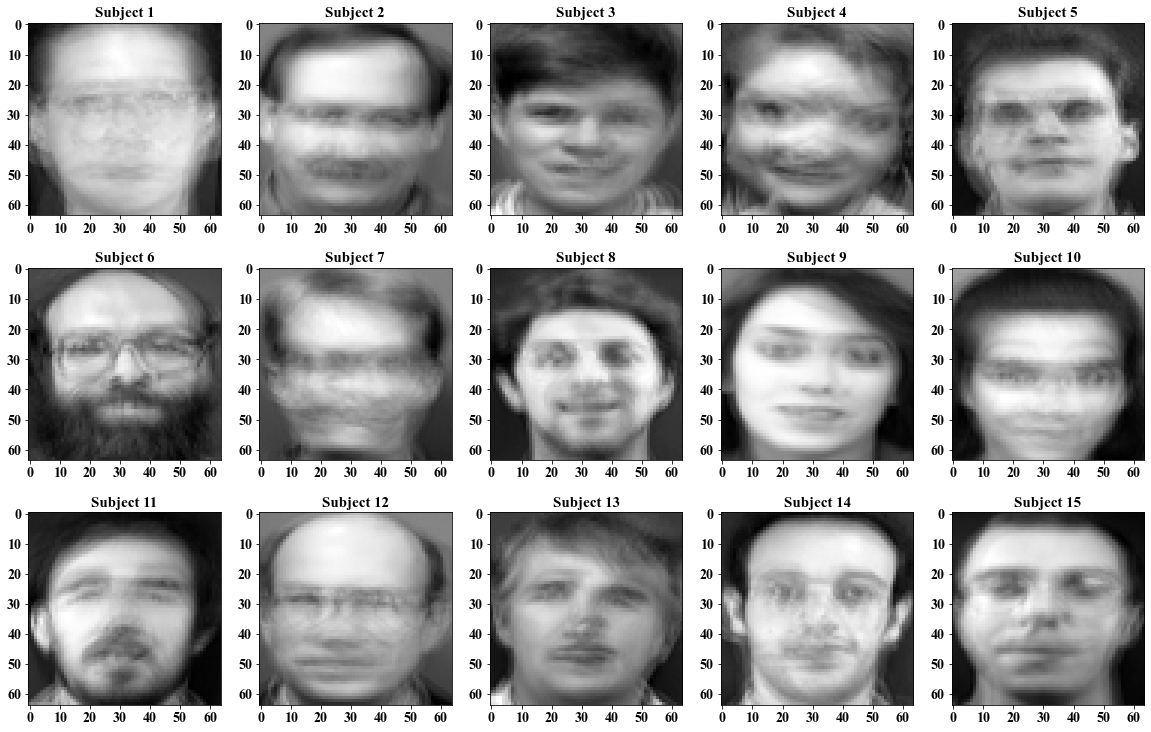

In [4]:
reprTensor = np.empty(shape=(height*width,len(listOfSubjects)))
fig, axs = plt.subplots(3,5, figsize=(20,13.5), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace=0.001, wspace=0.2)

for ax,i in zip(axs.ravel(),range(len(listOfSubjects))):
    
    os.chdir(listOfSubjects[i])  # Moving to subject directory
    trainingTensor = [[[0 for k in range(height)] for j in range(width)] for i in range(10)]
    trainingTensor = np.array(trainingTensor)
    reconstTensor = [[[0 for k in range(height)] for j in range(width)] for i in range(10)]
    reconstTensor = np.array(reconstTensor)
    sumTraining = [[0 for k in range(height)] for j in range(width)]
    sumTraining = np.array(sumTraining)
    
    for j in range(numOfImages):  # Generating the training tensor
        image = imread(listOfImages[j])
        trainingTensor[j] = image
    
    cumSum = np.zeros(width)
    for j in range(numOfImages):  # Performing SVD on all the training images to find an optimum rank of truncation
        image = trainingTensor[j]
        u, s, v = np.linalg.svd(image,full_matrices=False)
        S = np.diag(s)
        cumSum = cumSum + np.cumsum(np.diag(S))/np.sum(np.diag(S))
    cumSum = np.divide(cumSum,numOfImages)
        
    rank = np.max(np.where(cumSum>0.90))  # Choice of trucation rank (k) corresponding to 90% of energy captured
    
    for j in range(numOfImages):  # Reconstructing the images with the trucation rank
        image = trainingTensor[j]
        U, S, V = np.linalg.svd(image,full_matrices=False)
        S = np.diag(S)
        reconstImg = U[:,:rank]@S[0:rank,:rank]@V[:rank,:]
        reconstTensor[j] = reconstImg
    
    os.chdir(reprImgDirectory)
    sumImage = np.zeros((height,width))
    for j in range(numOfImages):
        image = reconstTensor[j]
        sumImage = np.add(sumImage,image)
    meanImage = np.divide(sumImage,numOfImages)
    ax.imshow(meanImage, cmap='gray')  # Plotting the representative images
    title = "Subject %s" %str(i+1)
    ax.set_title(title,fontname='Times New Roman',fontsize=15,weight='bold')
    ax.xaxis.set_major_locator(plt.MaxNLocator(7))
    ax.yaxis.set_major_locator(plt.MaxNLocator(7))
    for tick in ax.get_xticklabels():
        tick.set_fontname("Times New Roman")
        tick.set_fontsize(14)
    for tick in ax.get_yticklabels():
        tick.set_fontname("Times New Roman")
        tick.set_fontsize(14)
    reprTensor[:,i] = meanImage.flatten()
    fileName = "ReprImg %s.png" %str(i+1)
    plt.imsave(fileName,meanImage,cmap='gray')  # Saving the representative images
    image = imageio.imread(fileName)
    imageio.imwrite(fileName,image[:,:,0])
    
    os.chdir(parentDirectory)

#os.chdir(imagesDirectory)
#plt.gcf().subplots_adjust(left=0.05); plt.gcf().subplots_adjust(bottom=0.05)
#plt.savefig("representative_images.jpg", dpi=80);
#os.chdir(parentDirectory)

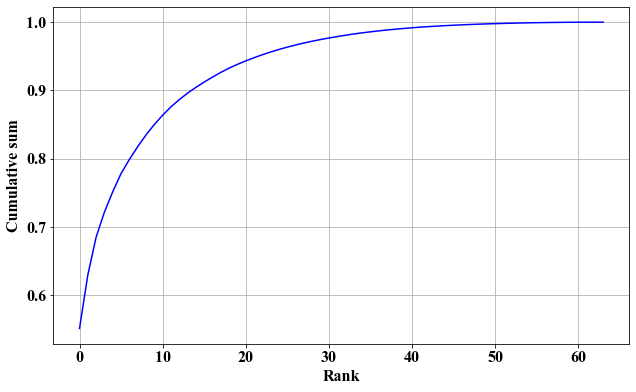

In [225]:
# Plotting the mean cumulative sum of the singular values (90% was used to truncate the rank)
plt.figure(figsize=(10,6))
plt.xlabel('Rank',family='Times New Roman',fontsize=16)
plt.ylabel('Cumulative sum',family='Times New Roman',fontsize=16)
plt.plot(cumSum,color='blue')
plt.xticks(family="Times New Roman",fontsize=16)
plt.yticks(family="Times New Roman",fontsize=16)
plt.grid()

#os.chdir(imagesDirectory)
#plt.gcf().subplots_adjust(left=0.1); plt.gcf().subplots_adjust(bottom=0.1)
#plt.savefig("cumulative_sum.jpg", dpi=80);
#os.chdir(parentDirectory)

#### Face recognition algorithm

##### Performing SVD on normalized representative images

In [6]:
normalizedRepImages = np.empty(shape=(height*width,len(listOfSubjects)))
os.chdir(reprImgDirectory)
listOfRepreImages = os.listdir(reprImgDirectory)
meanRepImage = np.mean(reprTensor,axis=1)
for col in range(len(listOfSubjects)):
    normalizedRepImages[:,col] = reprTensor[:,col]-meanRepImage  # Normalizing all images using the mean
os.chdir(parentDirectory)

u,s,v = np.linalg.svd(normalizedRepImages,full_matrices=False)  # Performing SVD on the normalized representative images
print(u.shape,s.shape,v.shape)

(4096, 15) (15,) (15, 15)


##### Testing the face recognition algorithm

In [190]:
# Dot product of all the images and U matrix
dotTraining = np.empty(shape=(u.shape[0]*u.shape[1],u.shape[1]))
temp = np.empty(shape=(u.shape[0],u.shape[1]))
for i in range(dotTraining.shape[1]):
    for col in range(u.shape[1]):    
        temp[:,col] = normalizedRepImages[:,i]*u[:,col]   # Dotting each training image with all columns of U
    dotTraining[:,i] = np.array(temp).flatten()

# Importing the test images and calculating the minimum norm
testSubject = np.zeros(len(listOfSubjects)*numOfImages,dtype='int')
predictedSubject = np.zeros(len(listOfSubjects)*numOfImages,dtype='int')
index = 0
os.chdir(testImgDirectory)
for i in range(len(listOfSubjects)):
    os.chdir(listOfSubjects[i])
    for j in range(numOfImages):
        fileName = "%s.pgm" %str(j+1)
        testImage = plt.imread(fileName).flatten()
        testImage = testImage-meanRepImage
        
        # Dot product of test image and U matrix
        test_x = np.empty(shape=(u.shape[0],u.shape[1]))
        for col in range(u.shape[1]):    
            test_x[:,col] = testImage*u[:,col]  # Dotting the test image with all columns of U
        dotTesting = np.array(test_x).flatten()
        
        # Difference between test data and training data
        difference = np.empty(shape=(u.shape[0]*u.shape[1],u.shape[1]))
        for col in range(u.shape[1]):
            difference[:,col] = dotTraining[:,col]-dotTesting[:]
        
        # Finding norm of all the columns
        norm = np.empty(shape=(u.shape[1],))
        for col in range(difference.shape[1]):    
            norm[col] = np.linalg.norm(difference[:,col])
        norm = list(norm)
        minIndex = norm.index(min(norm))
        testSubject[index] = i+1
        predictedSubject[index] = minIndex+1
        index += 1
        
    os.chdir('..')

##### Performance evaluation of the model

In [200]:
accuracy = 100*np.sum(testSubject==predictedSubject)/len(testSubject)
print('Accuracy = {:.2f}%'.format(accuracy))
confusionMat = pd.crosstab(testSubject,predictedSubject,rownames=['Actual'],colnames=['Predicted'],margins=True)
print('\nConfusion Matrix:\n-----------------')
print(confusionMat)

Accuracy = 99.33%

Confusion Matrix:
-----------------
Predicted   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  All
Actual                                                                    
1          10   0   0   0   0   0   0   0   0   0   0   0   0   0   0   10
2           0  10   0   0   0   0   0   0   0   0   0   0   0   0   0   10
3           0   0  10   0   0   0   0   0   0   0   0   0   0   0   0   10
4           0   0   0  10   0   0   0   0   0   0   0   0   0   0   0   10
5           0   0   0   0  10   0   0   0   0   0   0   0   0   0   0   10
6           0   0   0   0   0  10   0   0   0   0   0   0   0   0   0   10
7           0   0   0   0   0   0  10   0   0   0   0   0   0   0   0   10
8           0   0   0   0   0   0   0  10   0   0   0   0   0   0   0   10
9           0   0   0   0   0   0   0   0  10   0   0   0   0   0   0   10
10          0   0   0   0   0   0   0   0   0  10   0   0   0   0   0   10
11          0   0   0   0   0   0   0   0   0